In [333]:
import numpy as np
import pandas as pd
import seaborn as sns
import requests
import re
from bs4 import BeautifulSoup
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns
import scipy as sp

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from word2number import w2n

from datetime import datetime, timedelta

import re
from newspaper import Article
import unidecode
import contractions
import en_core_web_sm
import string

from textblob import TextBlob


In [375]:
data_dir = "./lithium_dataset"
cleaned_data_dir = "./lithium_dataset/cleaned_data"
results_dir = "./news_analysis2_results"

## Price Data Ingestion + Processing
- Consider lithium future, lithium metal spot, Li2CO3, and LIOH prices are potential regressands
- Clean each by calculating all available log returns with lags 1, 7, and 14 days
- According to Professor Geard, we'll only use data from 2021, which would include on average 500-600 datapoints
- Store them in jerry/lithium_dataset/cleaned_data

In [335]:
def convert_string_to_numeric(s):
    """
    Convert strings like '5.74M' or '532.50K' to numeric values
    """
    s = str(s).replace(',', '')  # Remove commas
    if 'M' in s:
        return float(s.replace('M', '')) * 1e6
    elif 'K' in s:
        return float(s.replace('K', '')) * 1e3
    else:
        return float(s)


def process_price_dataframe(df, price_cols, date_format, lags):

    # Convert columns in price_cols from string to numeric
    for col in price_cols:
        if type(df.loc[0,col]) == str:
            df[col] = df[col].apply(convert_string_to_numeric)
        else: 
            df[col] = df[col].astype(float)

    # Processing Dates
    df['Date'] = df['Date'].str.replace('.', '')
    df['Date'] = pd.to_datetime(df['Date'], format=date_format)
    for lag in lags:
        df[f'lag_{lag}'] = df.loc[:,'Date'] - timedelta(days=lag)
    df.set_index('Date', inplace=True)
    df = df.sort_index(ascending=True)
    for lag in lags:
        df[f'lag_{lag}_price'] = df[f'lag_{lag}'].apply(lambda x: df.loc[x,'Close'] if x in df.index else np.NaN)
        df = df.drop(columns=[f'lag_{lag}'])
        df[f'lag_{lag}_log_return'] = np.log(df['Close'] / df[f'lag_{lag}_price'])

    return df

In [336]:
regressands = ['60C-LTCX', '99C-LTCB', '995C-LTCB', '99MIN-LTMT', '999MIN-LTMT']
lags = [1,7,14]
all_data = {k: None for k in regressands}

all_data['li_future'] = pd.read_excel(f"{data_dir}/Historical Prices (9).xlsx")[['Date', 'Close']]
all_data['li2co3'] = pd.read_csv(f"{data_dir}/Lithium Carbonate (wind database).csv").rename(columns={'Li2CO3 99%': 'Close'})
all_data['lioh'] = pd.read_csv(f"{data_dir}/Lithium Hydroxide (wind database).csv").rename(columns={'LiOH 56.5%': 'Close'})
for reg in regressands:
    all_data[reg] = pd.read_csv(f"{data_dir}/{reg}.csv")[['Date', 'Price']].rename(columns={'Price':'Close'})

for reg in all_data.keys():
    if reg == 'li_future':
        all_data[reg] = process_price_dataframe(all_data[reg], price_cols=['Close'], date_format='%b %d, %Y', lags=lags)
    elif reg in ['li2co3', 'lioh']:
        all_data[reg] = process_price_dataframe(all_data[reg], price_cols=['Close'], date_format='%Y-%m-%d', lags=lags)
    else:
        all_data[reg] = process_price_dataframe(all_data[reg], price_cols=['Close'], date_format='%m/%d/%Y', lags=lags)
    all_data[reg].to_csv(f"{cleaned_data_dir}/{reg}_cleaned.csv")

all_data['li2co3']

/usr/local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/usr/local/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = geta

,Close,lag_1_price,lag_1_log_return,lag_7_price,lag_7_log_return,lag_14_price,lag_14_log_return
Date,,,,,,,
2005-01-04,23200.0,NaN,NaN,NaN,NaN,NaN,NaN
2005-01-05,23200.0,23200.0,0.000000,NaN,NaN,NaN,NaN
2005-01-06,23200.0,23200.0,0.000000,NaN,NaN,NaN,NaN
2005-01-07,23200.0,23200.0,0.000000,NaN,NaN,NaN,NaN
2005-01-10,23200.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...
2023-05-16,265000.0,258000.0,0.026770,195500.0,0.304169,NaN,NaN
2023-05-17,274000.0,265000.0,0.033398,208500.0,0.273189,NaN,NaN
2023-05-18,290000.0,274000.0,0.056753,225000.0,0.253781,179500.0,0.479706


## News Data Ingestion + Upstream/Downstream Segregation
- Use lithium_merged.csv as the source of all Lithium-related news
- Only keep news url and tone, which would be used to fetch all text contents --> NLP

In [337]:
news = pd.read_csv(f'{data_dir}/lithium_merged.csv')
news.set_index('DATE', inplace=True)
news.index = pd.to_datetime(news.index, format = '%Y%m%d%H%M%S')
news = news.sort_index(ascending = True)['2017-05-02':]
news = news[['DocumentIdentifier', 'V2Tone']].rename(columns={'DocumentIdentifier': 'url', 'V2Tone': 'tone'})

display(news)

,url,tone
DATE,,
2017-05-02 13:30:00,https://www.insiderfinancial.com/lithium-x-ene...,0.818554
2017-05-02 15:30:00,http://www.prnewswire.com/news-releases/hotter...,-1.374570
2017-05-03 06:00:00,http://www.einnews.com/pr_news/379071017/power...,0.000000
2017-05-03 11:00:00,http://www.einnews.com/pr_news/379118179/nemas...,-0.092593
2017-05-03 13:30:00,http://www.finanznachrichten.de/nachrichten-20...,0.207469
...,...,...
2023-05-30 22:00:00,https://www.sandiegoreader.com/news/2023/may/3...,-4.336043
2023-05-31 00:30:00,https://www.havasunews.com/nation/could-the-ru...,-3.505911
2023-05-31 12:00:00,https://www.finanznachrichten.de/nachrichten-2...,-0.213447


In [338]:
up_key1=['lithium-ore', 'nickel', 'cobalt','lithium-future','lithium-mining-companies', 'nickel-futures',
        'spodumene', 'spodumenite','lithium-market-share', 'cobalt-oxide', 'nickel-index', 'lithium-ore-reserves',
        'lithium-etf','lithium-index','lithium-concentration', 'industry-grade','battery-grade', 'li2co3', 'li-oh','lioh','lithium-mangnate',
        'lithium-iron-phosphate', 'ternary-materials', 'lithium-refining','lithium-carbonate','lithium-hydroxide','lithium-production']
up_key=up_key1

down_key1=['ev-car','electric-battery','lithium-battery', 'ev-car-subsidy','battery-subsidy', 'ev-company', 'ev-sales', 'ev-tax-credit','battery-tax-credit',
          'storage', 'lfp-battery','lithium-battery-companies','price-of-li-ion-battery','ternary-lithium-battery']
down_key=down_key1

for space in ["+","_","%20"," "]:
    up_key2=[sub.replace("-",space) for sub in up_key1]
    up_key=up_key+up_key2
    down_key2=[sub.replace("-",space) for sub in down_key1]
    down_key=down_key+down_key2

up_key=list(set(up_key))
down_key=list(set(down_key))

In [339]:
from multiprocessing import  Pool

lemmatizer = WordNetLemmatizer()

def process_text(text):

    # expand shortened words, e.g. don't to do not
    text = contractions.fix(text)
    
    # convert to lowercase
    text = text.lower()

    # remove newline characters
    text = re.sub('\n', ' ', text)

    # remove extra whitespace
    text = re.sub('\s+', ' ', text).strip()

    return text

def match_keyword(url, keywords):
    try:
        article = Article(url)
        article.download()
        article.parse()
        article.nlp()
        res = {
            'title': process_text(article.title),
            'text': process_text(article.text),
            'summary': process_text(article.summary),
            'keywords': article.keywords,
        }

        # sentence = TextBlob(res['text'])
        # for kw in keywords:
        #     print(kw, sentence.words.count(kw))
        # print(res['text'])
    
        for item in ['title', 'text', 'summary']:
            for kw in keywords:
                if lemmatizer.lemmatize(kw) in res[item]:
                    return True
        
        for item in res['keywords']:
            for kw in keywords:
                if lemmatizer.lemmatize(kw) in item:
                    return True
            
        return False
    
    except:
        return '1'
    
def add_categories(df):
    df['upstream'] = df['url'].apply(lambda x: match_keyword(x, up_key))
    df['downstream'] = df['url'].apply(lambda x: match_keyword(x, down_key))
    return df

In [340]:
# news1 = news.copy()[:12]
# news1 = add_categories(news1)
# display(news1)
# news1.to_csv(f'{cleaned_data_dir}/news_cat_cleaned.csv')

In [341]:
news_cat = pd.read_csv(f'{cleaned_data_dir}/news_cat_cleaned.csv')
display(news_cat)
print("Upstream count:", len(news_cat[news_cat['upstream'] == 'True']))
print("Downstream count:", len(news_cat[news_cat['downstream'] == 'True']))

,DATE,url,tone,upstream,downstream
0,2017-05-02 13:30:00,https://www.insiderfinancial.com/lithium-x-ene...,0.818554,False,False
1,2017-05-02 15:30:00,http://www.prnewswire.com/news-releases/hotter...,-1.374570,True,False
2,2017-05-03 06:00:00,http://www.einnews.com/pr_news/379071017/power...,0.000000,False,True
3,2017-05-03 11:00:00,http://www.einnews.com/pr_news/379118179/nemas...,-0.092593,True,True
4,2017-05-03 13:30:00,http://www.finanznachrichten.de/nachrichten-20...,0.207469,False,False
...,...,...,...,...,...
6681,2023-05-30 22:00:00,https://www.sandiegoreader.com/news/2023/may/3...,-4.336043,False,True
6682,2023-05-31 00:30:00,https://www.havasunews.com/nation/could-the-ru...,-3.505911,False,False
6683,2023-05-31 12:00:00,https://www.finanznachrichten.de/nachrichten-2...,-0.213447,True,False
6684,2023-05-31 13:00:00,https://www.finanznachrichten.de/nachrichten-2...,3.892028,True,True


Upstream count: 2424
Downstream count: 1312


# Entity Recognition

In [342]:
from gdeltdoc import GdeltDoc, Filters, near, repeat

### Lithium Midstream Companies

- 0TWH.LSE: Allkem LLC
- MIN.AX: Mineral Resources Ltd
- VAR1.STU: Varta AG
- 002340.SZ: GEM Co., Ltd
- 300919.SZ: CNGR Advanced Material Co Ltd
- 603799.SS: Zhejiang Huayou Cobalt Co.,Ltd
- 002125.SZ: Xiangtan Electrochemical Technology Co Ltd
- 300073.SZ: Beijing Easpring Material Technology
- 603659.SS: Shanghai Putailai New Energy Technology Co Ltd
- 600884.SS: Ningbo Shanshan Co Ltd
- 300035.SZ: Hunan Zhongke Electric
- 002812.SZ: Yunnan Energy New Material Co Ltd
- 300568.SZ: Shenzhen Senior Technology Material Co Ltd
- 002080.SZ: Sinoma Science & Technology Co Ltd
- 002709.SZ: Guangzhou Tinci Materials Technology Co Ltd
- 002407.SZ: Do-Fluoride New Materials Co Ltd
- 002759.SZ: TONZE NEW ENERGY TECHNOLOGY CO LTD

### Lithium Mining Companies

- SLI.USL: Standard Lithium Ltd
- ALB.US: Albemarle Corporation
- SQM.US: Sociedad Quimica y Minera de Chile SA
- 1772.Hk: Ganfeng Lithium Co Ltd
- 002466.SHE: Tianqi Lithium Corporation
- LTHM.US: Livent Corporation
- PLL.US: Piedmont Lithium Ltd
- LAC.US: Lithium Americas Corp
- GALXF.US: Galaxy Resources Limited
- ENS.US: EnerSys
- VUL.AU: Vulcan Energy Resources Limited
- EMHLF.US: European Metals Holdings Limited
- CRE.V: Critical Elements Corporation

### Lithium Mines

- Greenbushes Lithium Mine - Australia (owned by Talison Lithium, a joint venture between Tianqi Lithium and Albemarle)
- Salar del Hombre Muerto - Argentina (operated by Livent Corporation)
- Salar de Atacama - Chile (operated by SQM - Sociedad Química y Minera de Chile)
- Mt Cattlin Lithium Mine - Australia (owned by Galaxy Resources)
- Jiangxi Ganfeng Lithium Co., Ltd. - China (various mines)
- Bikita Minerals - Zimbabwe (operated by Bikita Minerals)
- Greenbushes Lithium Mine (Kuitpo) - Australia (owned by Mineral Resources Limited)
- Sichuan Tianqi Lithium Industries Inc. - China (various mines)
- Mibra Lithium Mine - Brazil (operated by Sigma Lithium Resources Corporation)
- Mariana Lithium Mine - Argentina (operated by Galaxy Resources)

### Lithium Battery Companies

- PCRFY.US: Japan's Panasonic is one of the world's largest producers of rechargeable lithium-ion batteries. The partnership with Tesla, in particular, has given Panasonic a significant presence in the field of electric vehicle batteries.

- 051910.KO: LG Chem is a South Korean chemical company and one of the world's largest manufacturers of lithium-ion batteries. The company provides batteries for electric vehicles, energy storage and mobility applications.

- 300750.SHE: CATL is a battery maker in China and one of the world's largest makers of batteries for electric vehicles. The company's customers include many international and Chinese electric vehicle manufacturers.

- 006400.KO: Samsung SDI, a subsidiary of South Korea's Samsung Group, is one of the world's leading manufacturers of batteries, whose products are widely used in electric vehicles, energy storage and mobile devices.

- MRAAF.US: Murata is also a producer of lithium-ion batteries, especially with a high market share in the field of small batteries. These batteries are mainly used in various mobile devices such as smartphones and laptops.

- 300014.SHE: The company's products include various types of lithium batteries, such as lithium-ion batteries, lithium-polymer batteries, lithium-iron-phosphorus batteries, etc., which are used in many fields, including consumer electronics, power tools, electric vehicles, energy storage, etc.

- ENR.US: Energizer is one of the largest battery manufacturers in the world, and its product line includes various types of batteries such as alkaline batteries, lithium batteries, rechargeable batteries, etc. Its "Energizer" and "Eveready" brands are well known around the world.

- 1211.HK: 1211.HK is the stock code of BYD Company Ltd. on the Hong Kong Stock Exchange. BYD is a world-leading high-tech company headquartered in Shenzhen, China, mainly engaged in the research and development, production and sales of automobiles, electronic equipment and new energy products.

- SONY.US: Sony is a world-renowned electronics manufacturer and entertainment company with a wide range of businesses, including the production of lithium batteries. In fact, Sony was the first company in the world to commercialize lithium-ion batteries, launching the world's first commercial lithium-ion batteries in 1991.`

### DLE (Direct Lithium Extraction) Companies

- Livent Corporation
- Sunresin New Materials
- Eramet Group
- International Battery Metals
- EnergySource Minerals
- Energy Exploration Technologies (EnergyX)
- Rio Tino
- Albemarle Corporation
- Sociedad Química y Minera (SQM)
- Compass Minerals International
- Standard Lithium
- Lilac Solutions
- Summit Nanotech
- IBC Advanced Technologies
- Controlled Thermal
- Occidential Petroleum
- Vulcan Energy Resources

In [343]:
midstream_list_clean = {
    "002340.SZ": ['Jingmen Gelinmei New Materials', 'Gelinmei New Materials', 'Gelinmei'],
    "300919.SZ": ["cngr advanced material", 'cngr'],
    "VAR1.STU":	['varta ag'],
    "603799.SS": ['Zhejiang Huayou Cobalt', 'Huayou Cobalt'],
    "002125.SZ": ['Xiangtan Electrochemical Technology', 'chinaemd', 'Xiangtan Electrochemical Scientific'],
    "300073.SZ": ['Beijing Easpring Material Tech', 'easpring'],
    "603659.SS": ['Shanghai Putailai New Energy Technology ', 'Shanghai Putailai', 'Putailai', 'Shanghai PTL'],
    "600884.SS": ['Ningbo Shanshan'],
    "300035.SZ": ['Hunan Zhongke Electric', 'zhongkeelectric', 'Zhongke Electric', 'Hunan Zhongke'],
    "002812.SZ": ['Yunnan Energy New Material'],
    "300568.SZ": ['Shenzhen Senior Technology Material', 'senior798.com'],
    "002080.SZ": ['Sinoma Science & Technology', 'Sinoma Science&Technology', 'Sinoma Science and Technology', 'sinomatech.com'],
    "002709.SZ": ['Tinci Materials', 'Guangzhou Tinci Materials Technology', 'Guangzhou Tinci'],
    "002407.SZ": ['Do-Fluoride New Materials', 'Do-Fluoride Chemicals', 'dfdchem.com'],
    "002759.SZ": ['TONZE NEW ENERGY TECHNOLOGY', 'Tonze New Energy', 'Tonze.com'],
    '0TWH.LSE':	['allkem', 'Orocobre', 'Allkem.co'],
    'MIN.AX': ['Mineral Resources Ltd', 'MinRes', 'ASX:MIN', 'Mineral Resources Limited', 'MIN.AU', 'MIN.AX'],
}


mining_co_list_clean = {
    "SLI.US": ["standard lithium"],
    "ALB.US": ["albemarle corp"],
    'SQM.US': ["sociedad quimica y minera de chile sa"],
    '1772.Hk': ["ganfeng lithium"],
    '002466.SHE': ["tianqi lithium"],
    'LTHM.US': ["livent corp"],
    'PLL.US': ["piedmont lithium"],
    'LAC.US': ["lithium americas"],
    'GALXF.US': [],
    'ENS.US': ["enersys"],
    'VUL.AU': ["vulcan energy resources"],
    'EMHLF.US': ["european metals holdings"],
    'CRE.V': ["critical elements"], 
}

lithium_mines_clean = {
    'Greenbushes Lithium Mine': ['greenbushes mine', 'greenbushes lithium', 'greenbushes project'],
    'Salar del Hombre Muerto': ['Salar del Hombre Muerto'],
    'Salar de Atacama': ['Salar de Atacama'],
    'Mt Cattlin Lithium Mine': ['Mt Cattlin Lithium Mine', 'Mt Cattlin Mine'],
    'Bikita Minerals': ['Bikita Minerals'],
    'Mibra Lithium Mine': ['Mibra lithium Mine', 'Mimbra Mine'],
    'Mariana Lithium Mine': ['Mariana Lithium'],
}

battery_co_list_clean = {
    'PCRFY.US': ['Panasonic'],
    '051910.KO': ['LG Chem'],
    '300750.SHE': ['contemporary amperex technology'],
    '006400.KO': ['Samsung'],
    'MRAAF.US': ['Murata'],
    '300014.SHE': ['EVE energy'],
    'ENR.US': ['Energizer'],
    '1211.HK': ['byd'],
    'SONY.US': ['sony'],
}

DLE_clean = {
	"LTHM": ["Livent"],
	"300487.SZ": ["Sunresin New Materials"],
	"": ["Eramet"],
	"IBAT.CN": ["International Battery Metals"],
	"": ["EnergySource Minerals"],
	"": ["EnergyX"],
	"RIO.AX": ["Rio Tinto"],
	"": ["Albemarle"],
	"": ["Sociedad Química y Minera", "SQM"],
	"CMP": ["Compass Minerals International"],
	"": ["Standard Lithium"],
	"": ["Lilac Solutions"],
	"": ["Summit Nanotech"],
	"": ["IBC Advanced Technologies"],
	"": ["Controlled Thermal"],
	"": ["Occidental Petroleum"],
	"VUL.AX": ["Vulcan Energy Resources"],
}


In [344]:
refining = [
    'Tianqi Lithium',
    'Ganfeng Lithium',
    'Mineral Resources Limited',
    'Pilbara Minerals',
    'Allkem Limited',
    'Lithium Americas',
    'Sichuan Yahua Group',
    'Livent',
    'Jiangxi Special Electric Motor',
    'Yongxing Special Materials Technology',
    'Sinomine Resource',
    'Altura Mining Limited',
    'Critical Elements Lithium Corporation',
    'Eramet SA',
    'Galaxy Resources Limited',
    'Infinity Lithium Corporation Limited',
    'Lithium Chile Inc.',
    'Lithium Power International Limited',
    'Lithium South Development Corporation',
    'Lithium Werks',
    'Lithium Energy Products',
    'Lithium Exploration Group',
    'Lithium Corporation',
    'LithiumOre Corp.',
    'Lithium X',
    'Lithium Energi Exploration',
    'Millennial Lithium Corp.',
    'Nemaska Lithium Inc.',
    'Neo Lithium Corp.',
    'North American Lithium Inc.',
    'Piedmont Lithium Limited',
    'Power Metals Corp.',
    'Pure Energy Minerals Limited',
    'QMC Quantum Minerals Corp.',
    'Rare Earth Salts',
    'Sigma Lithium Resources Corporation',
    'Sonora Lithium Ltd.',
]


mining = [
    'Lithium Americas',
    'Sichuan Yahua Group',
    'Allkem Limited',
    'Livent',
    'Mineral Resources Limited',
    'Pilbara Minerals',
    'Jiangxi Special Electric Motor',
    'Yongxing Special Materials Technology',
    'Sinomine Resource',
    'Altura Mining Limited',
    'Critical Elements Lithium Corporation',
    'Eramet SA',
    'Galaxy Resources Limited',
    'Infinity Lithium Corporation Limited',
    'International Lithium Corp.',
    'Lithium Chile Inc.',
    'Lithium South Development Corporation',
    'Lithium Werks',
    'Lithium Corporation',
    'Lithium X',
    'Lithium Energy Japan',
    'Lithium Energy Limited',
    'Lithium Urban Technologies',
    'Lithium Valley Technology',
    'LSC Lithium Corporation',
    'MGX Minerals Inc.',
    'QMC Quantum Minerals Corp.',
    'Sigma Lithium Resources Corporation',
    'Lithium Australia NL',
    'Lithium Ionic Corp.',
    'Arena Minerals Inc.',
    'Rock Tech Lithium Inc.',
    'American Lithium',
    'Wealth Minerals Ltd.',
    'Zadar Ventures Ltd.',
    'Lithium Power International',
    'Bacanora Lithium Ltd',
    'RB Energy',
    'Tianqi Lithium',
    'Ganfeng Lithium',
]

midstream = [
    'Ganfeng Lithium',
    'Livent',
    'General Lithium',
    'Neometals',
    'Eramet',
    'Nemaska Lithium',
    'Galaxy Resources',
    'Orocobre',
    'Piedmont Lithium',
    'Lithium Americas',
    'POSCO',
    'Tianqi Lithium',
    'Beta Hunt',
    'Sayona Mining',
    'Pilbara Minerals',
    'Altura Mining',
    'Kidman Resources',
    'Neo Lithium',
    'Bacanora Lithium',
    'Core Lithium',
    'European Metals',
    'Plateau Energy Metals',
    'Millennial Lithium',
    'Lake Resources',
]

In [394]:
redundant = ['co', 'plc', 'ltd', '&', 'inc', 'company', 'corp', 'corporation', 'limited']
redundant = redundant + [x + '.' for x in redundant] + ['.' + x for x in redundant]

def clean_bot(x):
    """
    The actual robot which is gonna clean the company suffix for every company.
    :type x: str
    :rtype: str
    """
    if x in ['lithium corporation']:
        return x
    x = x.split(' ')
    while len(x) > 0 and x[-1] in redundant:
        del x[-1]
    return ' '.join(x)

def compile_entity_names(dict_list):
    res = []
    for dict in dict_list:
        res = res + sum(list(dict.values()), [])
    res = map(lambda x: clean_bot(x.lower()), res)
    res = list(set(res))
    return sorted(list(set(res)))

def compile_entity_names2(listoflist):
    res = []
    for lst in listoflist:
        res = res + lst
    res = list(map(lambda x: clean_bot(x.lower()), res))
    return sorted(list(set(res)))

def company_in_string(str, mask):
    for m in mask:
        if m.lower() in str:
            return True
    return False

ALL_COMPANY_NAMES1 = compile_entity_names([mining_co_list_clean, lithium_mines_clean, DLE_clean])
ALL_COMPANY_NAMES2 = compile_entity_names2([refining, mining])

ALL_COMPANY_NAMES = sorted(list(set(ALL_COMPANY_NAMES1 + ALL_COMPANY_NAMES2)))
print(ALL_COMPANY_NAMES)
# for co in ALL_COMPANY_NAMES:
    # print(co)

ALL_MINING_COMPANY_NAMES = sorted(list(set(compile_entity_names([mining_co_list_clean, lithium_mines_clean]) + compile_entity_names2([mining]))))
# ALL_MINING_COMPANY_NAMES

['albemarle', 'allkem', 'altura mining', 'american lithium', 'arena minerals', 'bacanora lithium', 'bikita minerals', 'compass minerals international', 'critical elements', 'critical elements lithium', 'enersys', 'eramet sa', 'european metals holdings', 'galaxy resources', 'ganfeng lithium', 'greenbushes lithium', 'greenbushes mine', 'greenbushes project', 'infinity lithium', 'international battery metals', 'international lithium', 'jiangxi special electric motor', 'lithium americas', 'lithium australia nl', 'lithium chile', 'lithium corporation', 'lithium energi exploration', 'lithium energy', 'lithium energy japan', 'lithium energy products', 'lithium exploration group', 'lithium ionic', 'lithium power international', 'lithium south development', 'lithium urban technologies', 'lithium valley technology', 'lithium werks', 'lithium x', 'lithiumore', 'livent', 'lsc lithium', 'mariana lithium', 'mgx minerals', 'mibra lithium mine', 'millennial lithium', 'mimbra mine', 'mineral resources'

# GDELT News Data Analysis
### (Following Prof. Geert Bekaert's instructions in August 2, 2023 email communication)

In [346]:
gdelt_data_dir = "./GDELT_lithium_news"

In [347]:
all_news = pd.read_csv(f'{gdelt_data_dir}/lithium_news_clean.csv', index_col=0)
all_news.set_index('DATE', inplace=True)
all_news.index = pd.to_datetime(all_news.index, format = '%Y-%m-%d %H:%M:%S')
all_news = all_news.sort_index(ascending = True)
display(all_news)

,SourceCommonName,DocumentIdentifier,V2Tone,Themes,V2Organizations,FinalThemes
DATE,,,,,,
2016-01-01 00:00:00,thisismoney.co.uk,http://www.thisismoney.co.uk/money/markets/art...,-0.120482,NaN,"Rio Tinto,1867;Sabmiller,1961;Talk Talk Teleco...",NaN
2016-01-01 00:15:00,townsvillebulletin.com.au,http://www.townsvillebulletin.com.au/news/look...,0.647948,LEADER;TAX_FNCACT;TAX_FNCACT_MAYOR;MANMADE_DIS...,"National Disability,981;Rio Tinto,286;Central ...","MANMADE_DISASTER_IMPLIED,ENV_MINING,EDUCATION,..."
2016-01-01 00:15:00,townsvillebulletin.com.au,http://www.townsvillebulletin.com.au/news/look...,0.647948,LEADER;TAX_FNCACT;TAX_FNCACT_MAYOR;MANMADE_DIS...,"National Disability,981;Rio Tinto,286;Central ...","MANMADE_DISASTER_IMPLIED,ENV_MINING,EDUCATION,..."
2016-01-01 00:15:00,citywire.co.uk,http://citywire.co.uk/wealth-manager/news/over...,-0.476190,ENV_OIL;TAX_ECON_PRICE;ECON_OILPRICE;ECON_STOC...,"Chesapeake Energy Corp,459;Rio Tinto,866;Anglo...","ENV_OIL,ECON_STOCKMARKET,ENV_NATURALGAS,FUELPR..."
2016-01-01 00:30:00,4-traders.com,http://www.4-traders.com/LITHIUM-X-ENERGY-CORP...,0.920810,ECON_STOCKMARKET;WB_696_PUBLIC_SECTOR_MANAGEME...,"Company Stock Option Plan,140;Regulation Servi...","ECON_STOCKMARKET,LEGISLATION,TAX_ETHNICITY"
...,...,...,...,...,...,...
2023-08-03 18:00:00,politico.com,https://www.politico.com/news/2023/08/03/mongo...,-0.408998,EPU_ECONOMY;EPU_ECONOMY_HISTORIC;SOC_ECONCOOP;...,"Rio Tinto,874;Minerals Security Partnership,1344","SOC_ECONCOOP,ENV_MINING,TAX_ETHNICITY,ARMEDCON..."
2023-08-03 18:00:00,proactiveinvestors.co.uk,https://www.proactiveinvestors.co.uk/companies...,-0.890423,TAX_FNCACT;TAX_FNCACT_MANAGER;,"Warner Bros,11644;Civil Aerospace,29486;Us Dep...",NaN
2023-08-03 18:00:00,incomemagazine.ro,https://incomemagazine.ro/omv-petrom-si-romgaz...,1.188119,ENV_NATURALGAS;TAX_FNCACT;TAX_FNCACT_REGULATOR...,"Agency National For Mineral Resources,609;Stoc...","ENV_NATURALGAS,SLFID_MINERAL_RESOURCES,TAX_ETH..."


## Task 1: collect and analyze news for all mining companies on the list, 2016-2023

In [348]:
def get_news_subset(news_df, company_names=None, year=None, month=None, day=None):

    def company_in_string(str, co_list):
        for c in co_list:
            if c.lower() in str.lower():
                return True
        return False

    mask = news_df.index != 0
    if year is not None:
        mask = mask & (news_df.index.year == year)
    if month is not None:
        mask = mask & (news_df.index.month == month)
    if day is not None:
        mask = mask & (news_df.index.day == day)
    if company_names is not None:
        mask = mask & (news_df['V2Organizations'].apply(lambda x: company_in_string(x, company_names)))
    
    df = news_df[mask]
    return df

def get_available_days(news_df):
    df = list(news_df.index.strftime('%Y-%m-%d'))
    df = sorted(list(set(df)))
    return df

In [349]:
def process_news_data(news_df_):
    res = {}
    news_df = news_df_.copy()
    news_df.loc[:,'FinalThemes'] = news_df['FinalThemes'].map(lambda x: x.split(','))

    res['news_urls'] = news_df['DocumentIdentifier'].tolist()
    res['tone_mean'] = news_df['V2Tone'].mean()
    res['tone_std'] = news_df['V2Tone'].std()
    res['news_count'] = len(news_df)
    themes = sorted(news_df['FinalThemes'].explode().tolist())
    # unique_themes = sorted(list(set(themes))) 
    res['news_themes'] = themes
    res['news_theme_occurence'] = {item: themes.count(item) for item in themes}

    # clusters = list(set(Theme['cluster_label']))
    # cluster_count = {k: 0 for k in clusters}
    # for x in themes:
    #     label = Theme.loc[x,'cluster_label']
    #     cluster_count[label] = cluster_count[label] + 1
    # res['cluster_count'] = cluster_count

    return res

def calculate_statistics(news_df):
    if len(news_df) == 0:
        return {
            'num_days': 0,
            'tone_mean': np.nan,
            'tone_std': np.nan,
            'num_news': 0,
            'news_per_available_day': 0
        }
    res = {}
    res['num_days'] = len(get_available_days(news_df))
    res['tone_mean'] = news_df['V2Tone'].mean()
    res['tone_std'] = news_df['V2Tone'].std()
    res['num_news'] = len(news_df)
    res['news_per_available_day'] = len(news_df) / res['num_days']
    return res

### Summary data on the number of news articles for each company in each year

In [350]:
import json

with open("./news_processing_scripts/taxonomy.json") as f:
    taxonomy = json.load(f)

In [351]:
summary = []
for company in taxonomy['mining'].keys():
    company_summary = []
    company_summary.append(len(get_news_subset(news_df=all_news, company_names=taxonomy['mining'][company])))
    for year in range(2016, 2024):
        company_summary.append(len(get_news_subset(news_df=all_news, company_names=taxonomy['mining'][company], year=year)))
    summary.append(company_summary)
    print(f"{company} data processed")

Albemarle Corporation data processed
Allkem Limited data processed
Altura Mining Limited data processed
American Lithium data processed
Arena Minerals Inc. data processed
Critical Elements Lithium Corporation data processed
Bacanora Lithium Ltd data processed
EnerSys data processed
Eramet SA data processed
European Metals Holdings Limited data processed
Galaxy Resources Limited data processed
Ganfeng Lithium Co Ltd data processed
Infinity Lithium Corporation Limited data processed
International Lithium Corp. data processed
Jiangxi Special Electric Motor data processed
Lithium Americas Corporation data processed
Lithium Energy Limited data processed
Lithium Chile Inc. data processed
Lithium Corporation data processed
Lithium Ionic Corp. data processed
Lithium Power International data processed
Lithium South Development Corporation data processed
Lithium X Energy Corp. data processed
Livent Corporation data processed
LSC Lithium Corporation data processed
Mineral Resources Limited data p

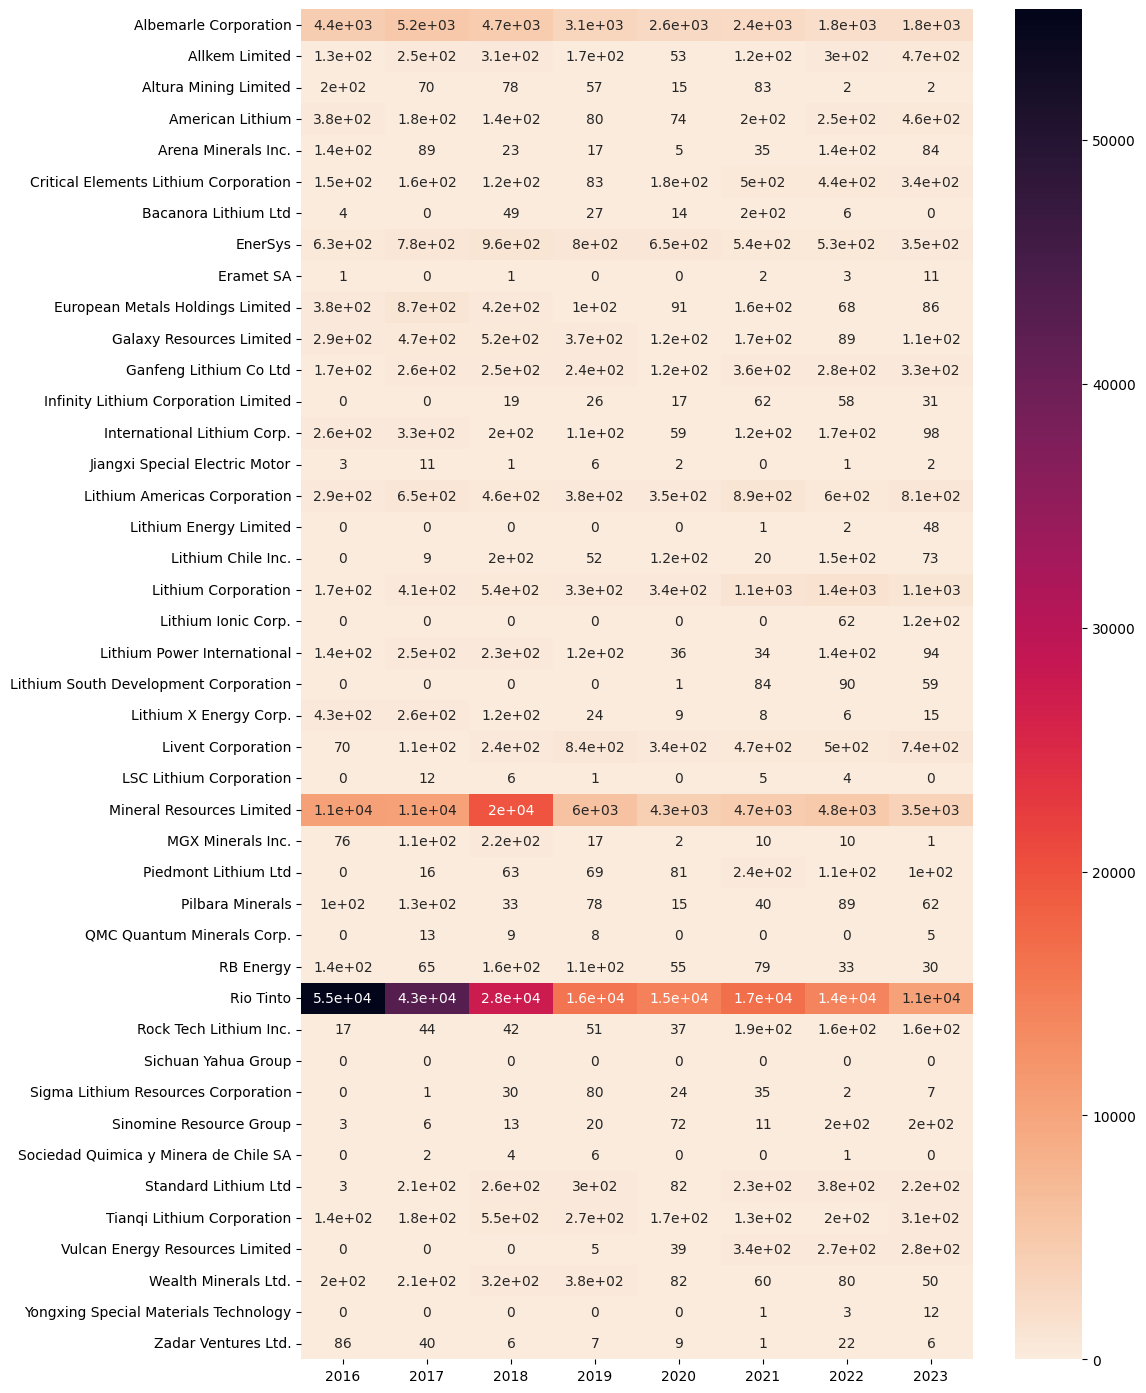

In [401]:
summary_df = pd.DataFrame(summary, index=taxonomy['mining'].keys(), columns=['2016-2023'] + [str(i) for i in range(2016, 2024)])

fig, ax = plt.subplots(figsize = (12, 15))
sns.heatmap(summary_df[[str(i) for i in range(2016, 2024)]], annot=True, cmap=sns.color_palette("rocket_r", as_cmap=True))
plt.subplots_adjust(left=0.3, right=1, bottom=0.05, top=0.95)
plt.savefig(f"{results_dir}/task1_count_heatmap.png")

### Summary statistics of news, per company per year

In [406]:
summary2 = []
for company in taxonomy['mining'].keys():

    df = get_news_subset(news_df=all_news, company_names=taxonomy['mining'][company])
    res_dict = {'company': company, 'year': '2016-2023'}
    res_dict = res_dict | calculate_statistics(df)
    res_dict = res_dict | {'news_per_calendar_day': 2771}
    summary2.append(res_dict)

    for year in range(2016, 2024):
        df = get_news_subset(news_df=all_news, company_names=taxonomy['mining'][company], year=year)
        res_dict = {'company': company, 'year': year}
        res_dict = res_dict | calculate_statistics(df)
        res_dict = res_dict | {'news_per_calendar_day': len(df) / (366 if year in [2016, 2020] else 365)}
        summary2.append(res_dict)
    print(f"{company} data processed")

Albemarle Corporation data processed
Allkem Limited data processed
Altura Mining Limited data processed
American Lithium data processed
Arena Minerals Inc. data processed
Critical Elements Lithium Corporation data processed
Bacanora Lithium Ltd data processed
EnerSys data processed
Eramet SA data processed
European Metals Holdings Limited data processed
Galaxy Resources Limited data processed
Ganfeng Lithium Co Ltd data processed
Infinity Lithium Corporation Limited data processed
International Lithium Corp. data processed
Jiangxi Special Electric Motor data processed
Lithium Americas Corporation data processed
Lithium Energy Limited data processed
Lithium Chile Inc. data processed
Lithium Corporation data processed
Lithium Ionic Corp. data processed
Lithium Power International data processed
Lithium South Development Corporation data processed
Lithium X Energy Corp. data processed
Livent Corporation data processed
LSC Lithium Corporation data processed
Mineral Resources Limited data p

In [407]:
summary_df2 = pd.DataFrame(summary2)
summary_df2

,company,year,num_days,tone_mean,tone_std,num_news,news_per_available_day,news_per_calendar_day
0,Albemarle Corporation,2016-2023,2706,-0.225828,3.349617,26023,9.616778,2771.000000
1,Albemarle Corporation,2016,364,-0.414669,3.749050,4450,12.225275,12.158470
2,Albemarle Corporation,2017,363,-0.453176,3.280642,5173,14.250689,14.172603
3,Albemarle Corporation,2018,365,-0.402515,3.440208,4662,12.772603,12.772603
4,Albemarle Corporation,2019,361,0.079039,3.365124,3082,8.537396,8.443836
...,...,...,...,...,...,...,...,...
382,Zadar Ventures Ltd.,2019,7,-0.316663,1.403925,7,1.000000,0.019178
383,Zadar Ventures Ltd.,2020,5,3.385516,0.895151,9,1.800000,0.024590
384,Zadar Ventures Ltd.,2021,1,0.441826,NaN,1,1.000000,0.002740
385,Zadar Ventures Ltd.,2022,22,1.140943,0.122555,22,1.000000,0.060274


In [409]:
summary_df.to_csv("./news_analysis2_results/task1_count_heatmap.csv")
summary_df2.to_csv("./news_analysis2_results/task1_stats_results.csv")

## Task2: Understand the news articles on Lithium (both URL matching & organization matching)

In [369]:
all_news2 = pd.read_csv(f'../lithium_dash/lithium_merged.csv', index_col=0)
all_news2.set_index('DATE', inplace=True)
all_news2.index = pd.to_datetime(all_news2.index, format = '%Y%m%d%H%M%S')
all_news2 = all_news2.sort_index(ascending = True)["2016-01-01 00:00:00":]
all_news2['V2Tone'] = all_news2['V2Tone'].apply(lambda x: float(x.split(',')[0]))
all_news2 = all_news2.rename(columns={'Organizations': 'V2Organizations'})

all_news3 = pd.concat([all_news[['SourceCommonName', 'DocumentIdentifier', 'V2Tone', 'V2Organizations']],
                       all_news2[['SourceCommonName', 'DocumentIdentifier', 'V2Tone', 'V2Organizations']]])

all_news3.drop_duplicates(keep='first', subset=['DocumentIdentifier'], inplace=True)
all_news3.to_csv("GDELT_lithium_news/lithium_news_merged.csv")
display(all_news3)

,SourceCommonName,DocumentIdentifier,V2Tone,V2Organizations
DATE,,,,
2016-01-01 00:00:00,thisismoney.co.uk,http://www.thisismoney.co.uk/money/markets/art...,-0.120482,"Rio Tinto,1867;Sabmiller,1961;Talk Talk Teleco..."
2016-01-01 00:15:00,townsvillebulletin.com.au,http://www.townsvillebulletin.com.au/news/look...,0.647948,"National Disability,981;Rio Tinto,286;Central ..."
2016-01-01 00:15:00,townsvillebulletin.com.au,http://www.townsvillebulletin.com.au/news/look...,0.647948,"National Disability,981;Rio Tinto,286;Central ..."
2016-01-01 00:15:00,citywire.co.uk,http://citywire.co.uk/wealth-manager/news/over...,-0.476190,"Chesapeake Energy Corp,459;Rio Tinto,866;Anglo..."
2016-01-01 00:30:00,4-traders.com,http://www.4-traders.com/LITHIUM-X-ENERGY-CORP...,0.920810,"Company Stock Option Plan,140;Regulation Servi..."
...,...,...,...,...
2023-05-31 15:15:00,miningweekly.com,https://www.miningweekly.com/article/portugal-...,1.955307,NaN
2023-05-31 15:30:00,etftrends.com,https://www.etftrends.com/gold-silver-investin...,2.298851,national australia bank
2023-05-31 15:45:00,namibiansun.com,http://www.namibiansun.com/business/justin-chi...,0.995025,jiangxi jinhui lithium co;lepidico chemicals n...


In [357]:
summary3 = []
summary4 = []
summary5 = []

for year in range(2016, 2024):
    df = get_news_subset(news_df=all_news3, year=year)
    res_dict = {'year': year}
    res_dict = res_dict | calculate_statistics(df)
    summary3.append(res_dict)

for year in range(2016, 2024):
    for month in (range(1, 8) if year == 2023 else range(1, 13)):
        df = get_news_subset(news_df=all_news3, year=year, month=month)
        res_dict = {'month': pd.Timestamp(f'{year}-{month}-01')}
        res_dict = res_dict | calculate_statistics(df)
        summary4.append(res_dict)

In [358]:
summary5 = []

for index in pd.date_range(start='1/1/2016', end='8/3/2023'):
    df = get_news_subset(news_df=all_news3, year=index.year, month=index.month, day=index.day)
    res_dict = {'date': index}
    res_dict = res_dict | calculate_statistics(df)
    summary5.append(res_dict)

In [359]:
summary_df3 = pd.DataFrame(summary3)
summary_df3.set_index('year', inplace=True)
display(summary_df3)
summary_df3.to_csv("./news_analysis2_results/task2_annual_results.csv")

summary_df4 = pd.DataFrame(summary4)
summary_df4.set_index('month', inplace=True)
display(summary_df4)
summary_df4.to_csv("./news_analysis2_results/task2_monthly_results.csv")

,num_days,tone_mean,tone_std,num_news,news_per_available_day
year,,,,,
2016,366,-0.687102,2.269412,87430,238.879781
2017,365,-0.304362,2.223013,77546,212.454795
2018,365,-0.577589,2.317346,71698,196.432877
2019,365,-0.196590,2.447565,46931,128.578082
2020,366,-0.864425,2.505413,38427,104.991803
2021,365,-0.109364,2.302206,44241,121.208219
2022,365,-0.161479,2.332685,45486,124.619178
2023,215,0.002527,2.269887,33786,157.144186


,num_days,tone_mean,tone_std,num_news,news_per_available_day
month,,,,,
2016-01-01,31,-1.450229,2.319029,7077,228.290323
2016-02-01,29,-1.071625,2.202634,8857,305.413793
2016-03-01,31,-0.687107,2.258695,7427,239.580645
2016-04-01,30,-0.590036,2.118036,6883,229.433333
2016-05-01,31,-0.456254,2.080846,7796,251.483871
...,...,...,...,...,...
2023-03-01,31,-0.042339,2.351058,4472,144.258065
2023-04-01,30,0.041165,2.327372,5509,183.633333
2023-05-01,31,0.262005,2.144806,6937,223.774194


In [360]:
summary_df5 = pd.DataFrame(summary5)
summary_df5.set_index('date', inplace=True)
display(summary_df5)
summary_df5.to_csv("./news_analysis2_results/task2_daily_results.csv")

,num_days,tone_mean,tone_std,num_news,news_per_available_day
date,,,,,
2016-01-01,1,-0.865501,2.082844,65,65.0
2016-01-02,1,-0.494813,2.063865,35,35.0
2016-01-03,1,-0.610899,1.463926,41,41.0
2016-01-04,1,-1.796279,2.017478,269,269.0
2016-01-05,1,-1.067428,2.151359,267,267.0
...,...,...,...,...,...
2023-07-30,1,-0.769882,2.063053,54,54.0
2023-07-31,1,0.953291,2.055953,205,205.0
2023-08-01,1,-0.333499,2.383566,293,293.0


### Report time-series graph of news volume & tone

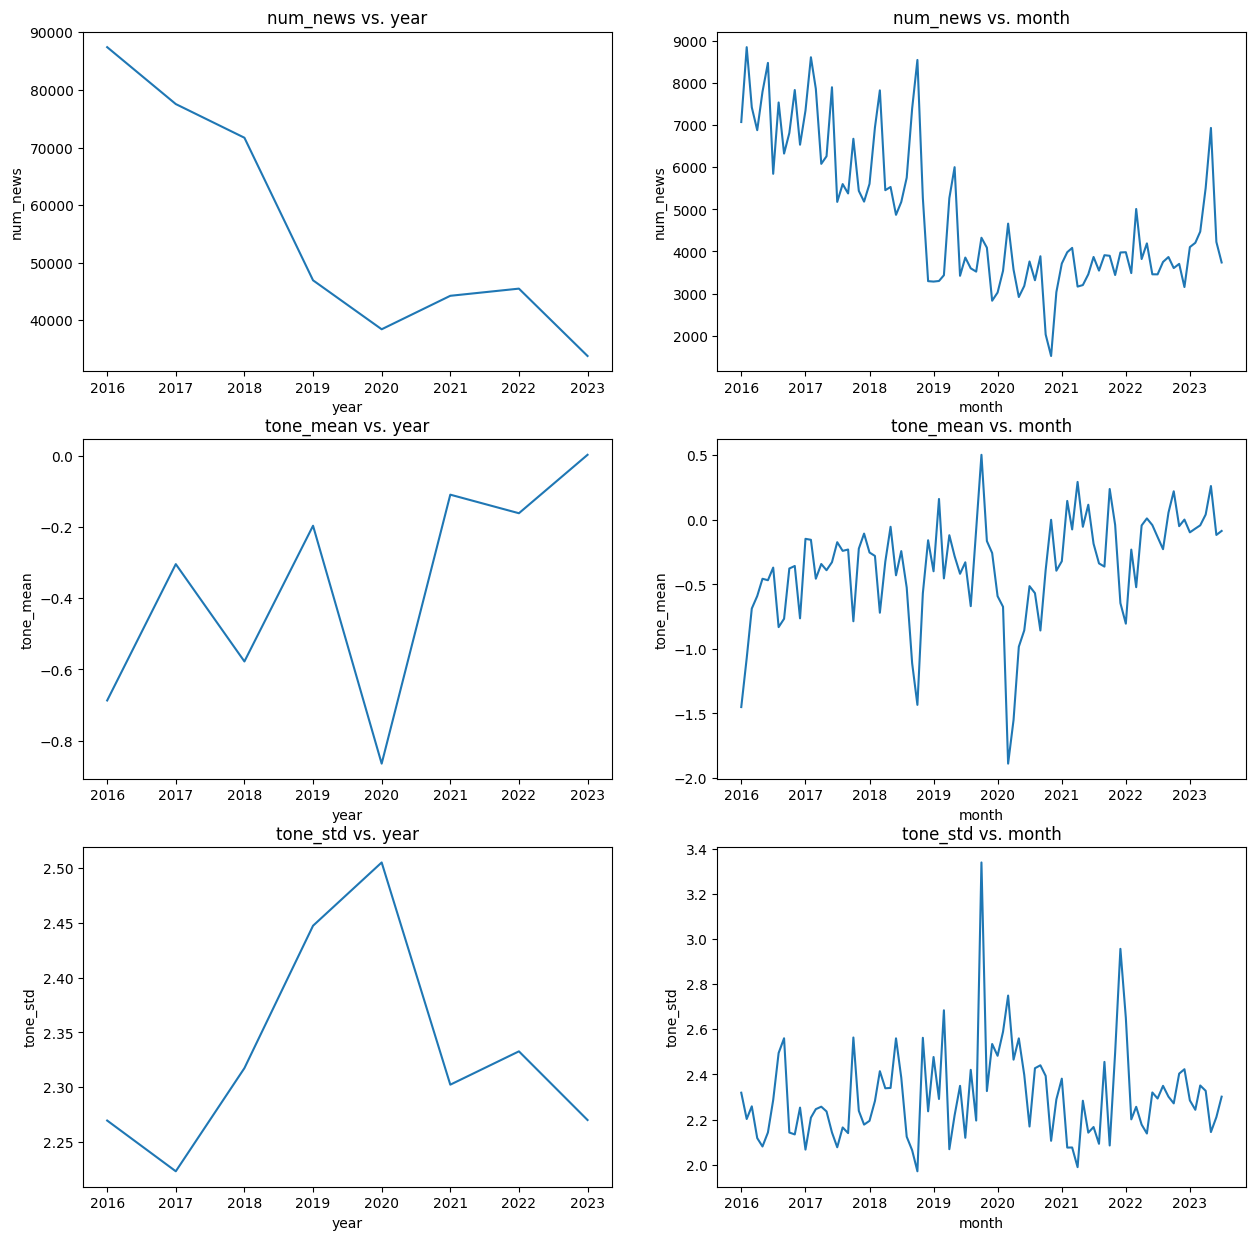

In [396]:
# Ploting historical close prices
fig, ax = plt.subplots(3, 2)

df_lst = [summary_df3, summary_df4, summary_df5]
time_lst = ['year', 'month', 'date']
metric_lst = ['num_news', 'tone_mean', 'tone_std']

for i in range(3): # metric
    for j in range(2): # timeframe
        ax[i,j].plot(df_lst[j][metric_lst[i]])
        ax[i,j].set_title(f"{metric_lst[i]} vs. {time_lst[j]}")
        ax[i,j].set_xlabel(f"{time_lst[j]}")
        ax[i,j].set_ylabel(f"{metric_lst[i]}")
        
fig.set_figheight(15)
fig.set_figwidth(15)
plt.savefig(f"{results_dir}/task2_ts_graph1.png")

plt.show()

slope = -4.866997e-02 (num_news/day), r-squared = -3.480945e-01
slope = 1.626027e-04 (tone_mean/day), r-squared = 1.787054e-01
slope = 1.174701e-05 (tone_std/day), r-squared = 2.056655e-02


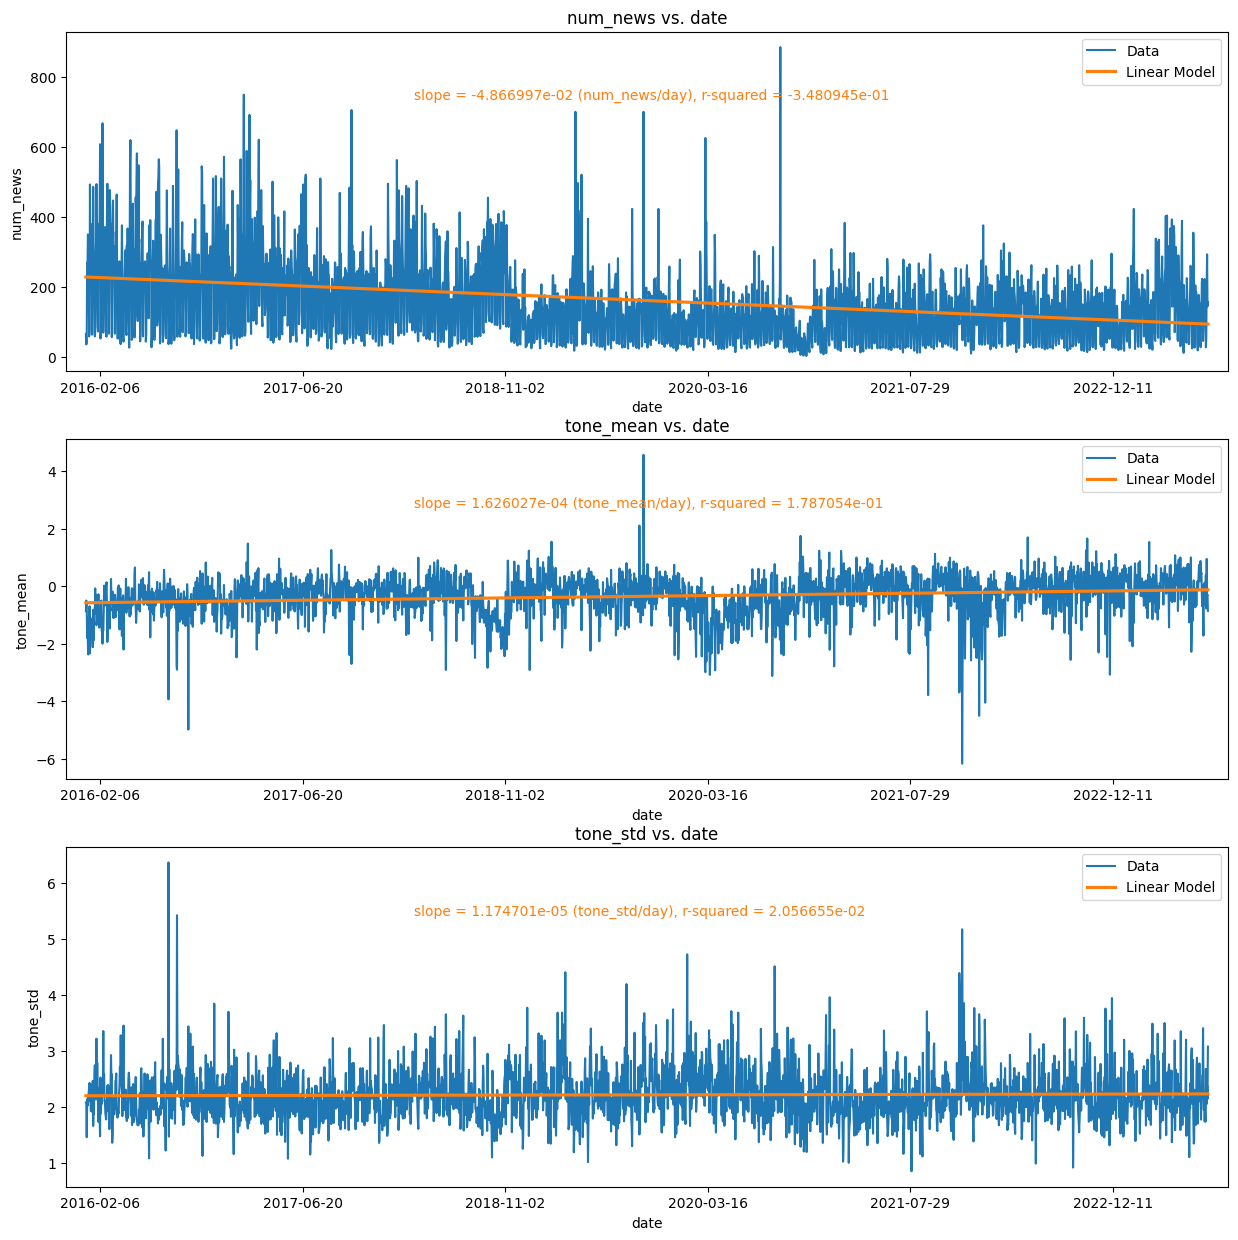

In [410]:
fig, ax = plt.subplots(3, 1)

metric_lst = ['num_news', 'tone_mean', 'tone_std']

summary_df5_ = summary_df5.copy()
summary_df5_.index = summary_df5_.index.map(pd.Timestamp.toordinal)
data=summary_df5_.reset_index()
data['adj_date'] = data.index

for i in range(3): # metric
    ax[i].plot(summary_df5_[metric_lst[i]], label='Data')
    ax[i].set_title(f"{metric_lst[i]} vs. date")
    ax[i].set_xlabel(f"date")
    ax[i].set_ylabel(f"{metric_lst[i]}")

    p = sns.regplot(data=data, x='date', y=metric_lst[i], ax=ax[i], color='tab:orange', scatter_kws={'s': 7}, label='Linear Model', scatter=False)
    slope, intercept, r, p, sterr = sp.stats.linregress(x=p.get_lines()[0].get_xdata(),
                                                        y=p.get_lines()[0].get_ydata())

    xticks = ax[i].get_xticks()
    labels = [pd.Timestamp.fromordinal(int(label)).date() for label in xticks]
    ax[i].set_xticks(xticks)
    ax[i].set_xticklabels(labels)

    ax[i].set_xlim(summary_df5_.index[0]-50, summary_df5_.index[-1]+50)
    ax[i].legend()

    txt = f"slope = {slope:.6e} ({metric_lst[i]}/day), r-squared = {r:.6e}"
    print(txt)
    ax[i].text(0.3, 0.8, txt, transform=ax[i].transAxes, color='tab:orange')

fig.set_figheight(15)
fig.set_figwidth(15)

plt.savefig(f"{results_dir}/task2_ts_graph2.png")

### Report number of news items per day and trace a histogram

In [397]:
daily_distribution = summary_df5[['num_news', 'tone_mean', 'tone_std']].describe()
daily_distribution.loc['IQR',:] = daily_distribution.loc['75%',:] - daily_distribution.loc['25%',:]
daily_distribution.loc['lower whisker',:] = daily_distribution.loc['25%',:] - daily_distribution.loc['IQR',:] * 1.5
daily_distribution.loc['upper whisker',:] = daily_distribution.loc['75%',:] + daily_distribution.loc['IQR',:] * 1.5

display(daily_distribution)
daily_distribution.to_csv(f"{results_dir}/task2_daily_distribution.csv")


,num_news,tone_mean,tone_std
count,2772.000000,2772.000000,2772.000000
mean,160.730519,-0.346381,2.220295
std,111.903800,0.728234,0.457137
min,2.000000,-6.170581,0.856169
25%,72.000000,-0.695334,1.929724
50%,142.000000,-0.248064,2.161766
75%,220.000000,0.136633,2.458001
max,886.000000,4.576719,6.367459
IQR,148.000000,0.831967,0.528277
lower whisker,-150.000000,-1.943285,1.137308


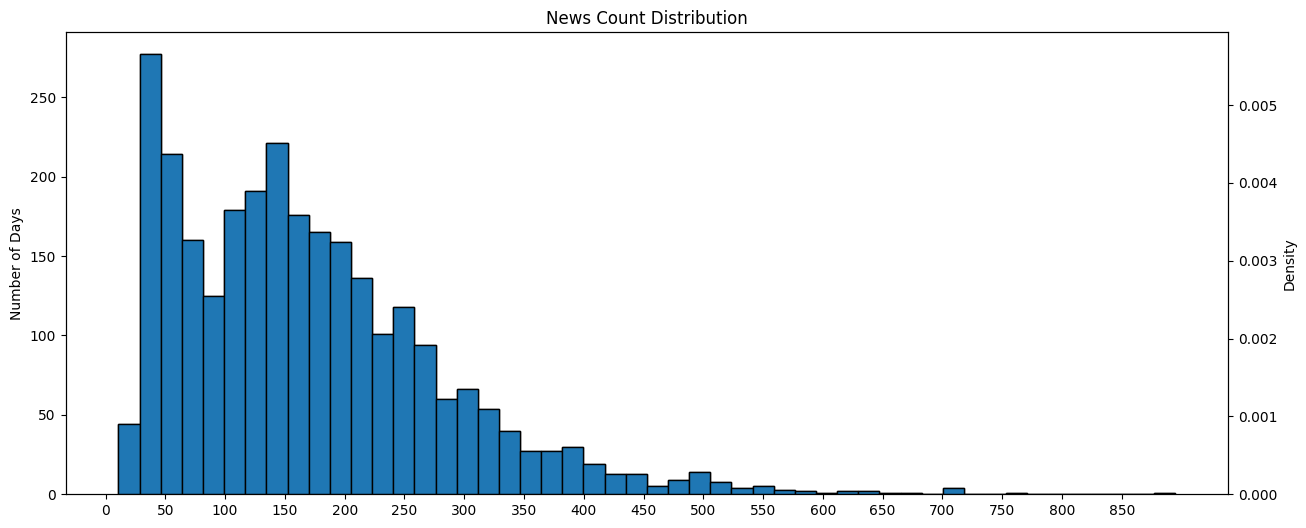

In [398]:
fig, ax = plt.subplots(figsize=(15,6))

ax.hist(summary_df5['num_news'], 
        bins=50, 
        align='right', 
        edgecolor='black')

ax2 = ax.twinx()
ax2.hist(summary_df5['num_news'], 
         density = True,
         bins=50, 
         align='right', 
         edgecolor='black')

plt.xticks(np.arange(0, max(summary_df5['num_news'])+1, 50))
plt.xlabel('Number of News Items per Day')
ax.set_ylabel('Number of Days')
ax2.set_ylabel('Density')
plt.title('News Count Distribution')

plt.savefig(f"{results_dir}/task2_count_histogram.png")

### Report average tone per day statistics

-8.0 6.0


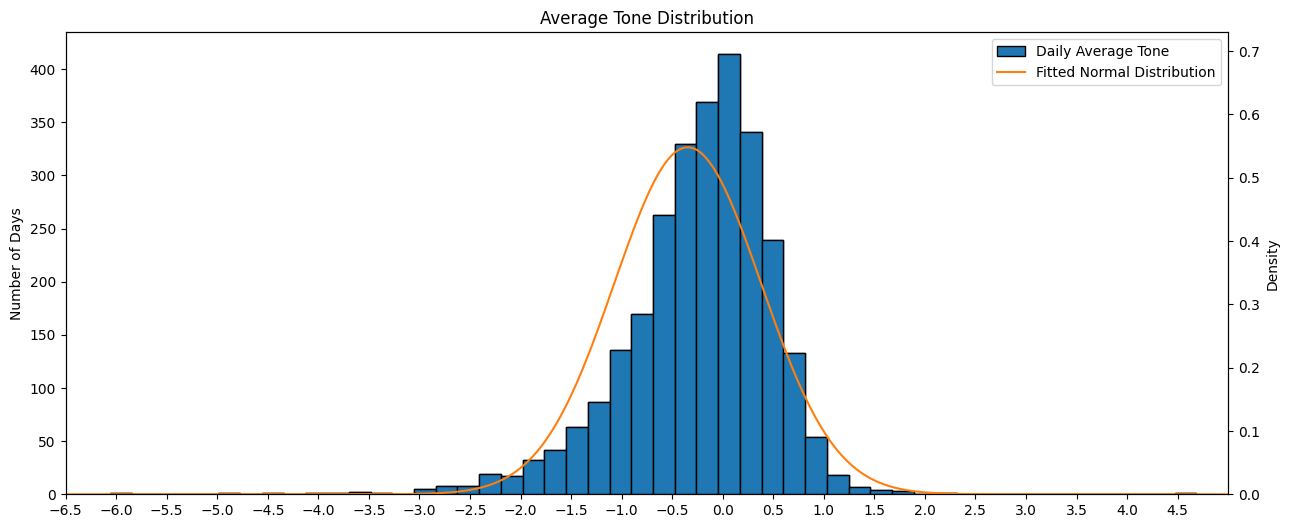

In [399]:
fig, ax = plt.subplots(figsize=(15,6))

ax.hist(summary_df5['tone_mean'], 
        bins=50, 
        align='right', 
        edgecolor='black',
        label="Daily Average Tone")

ax2 = ax.twinx()
ax2.hist(summary_df5['tone_mean'], 
         density=True,
         bins=50, 
         align='right', 
         edgecolor='black',
         label="Daily Average Tone")

xt = plt.xticks()[0]
xmin, xmax = min(xt), max(xt)  
print(xmin, xmax)

lnspc = np.linspace(xmin, xmax, len(summary_df5['tone_mean']))
m, s = sp.stats.norm.fit(summary_df5['tone_mean']) # get mean and standard deviation  
pdf_g = sp.stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Fitted Normal Distribution") # plot it

plt.xlim(-6, 5)
plt.xticks(np.arange(-6.5, 5, 0.5))
plt.xlabel('Average Tone of News in a Day')
ax.set_ylabel('Number of Days')
ax2.set_ylabel('Density')
plt.title('Average Tone Distribution')
plt.legend()

plt.savefig(f"{results_dir}/task2_tone_mean_histogram.png")

### Report standard deviation per day statistics

0.0 7.0


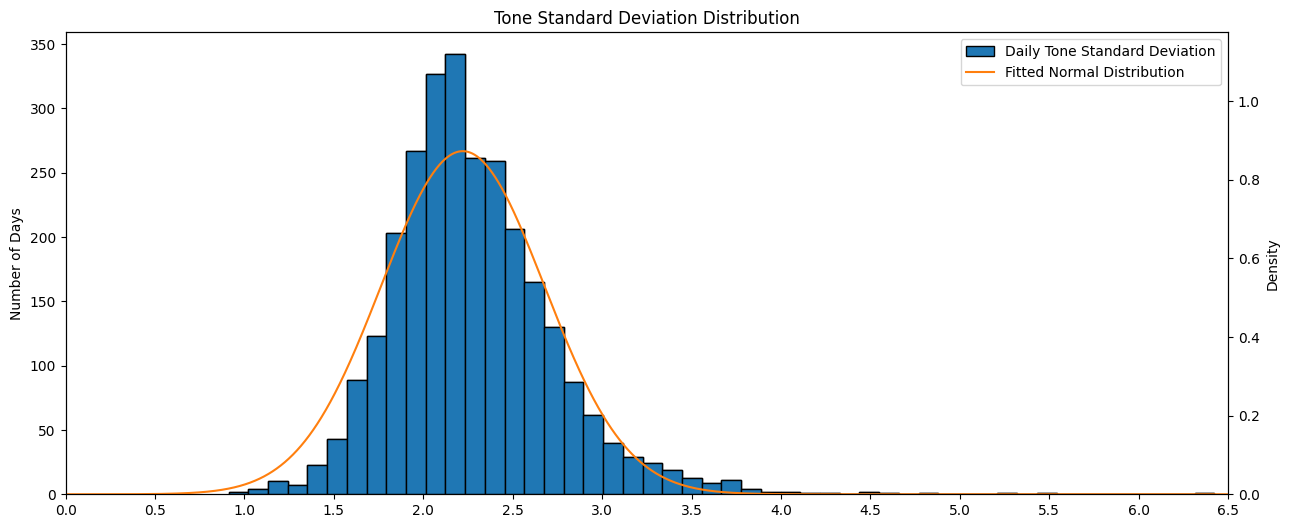

In [421]:
fig, ax = plt.subplots(figsize=(15,6))

ax.hist(summary_df5['tone_std'], 
        bins=50, 
        align='right', 
        edgecolor='black',
        label="Daily Tone Standard Deviation")

ax2 = ax.twinx()
ax2.hist(summary_df5['tone_std'], 
         density = 1,
         bins=50, 
         align='right', 
         edgecolor='black',
         label="Daily Tone Standard Deviation")

xt = plt.xticks()[0]
xmin, xmax = min(xt), max(xt)  
print(xmin, xmax)

lnspc = np.linspace(xmin, xmax, len(summary_df5['tone_std']))
m, s = sp.stats.norm.fit(summary_df5['tone_std']) # get mean and standard deviation  
pdf_g = sp.stats.norm.pdf(lnspc, m, s) # now get theoretical values in our interval  
plt.plot(lnspc, pdf_g, label="Fitted Normal Distribution") # plot it

plt.xlim(0, 6)
plt.xticks(np.arange(0, 7, 0.5))
plt.xlabel('Tone Std of News in a Day')
ax.set_ylabel('Number of Days')
ax2.set_ylabel('Density')
plt.title('Tone Standard Deviation Distribution')
plt.legend()

plt.savefig(f"{results_dir}/task2_tone_std_histogram.png")

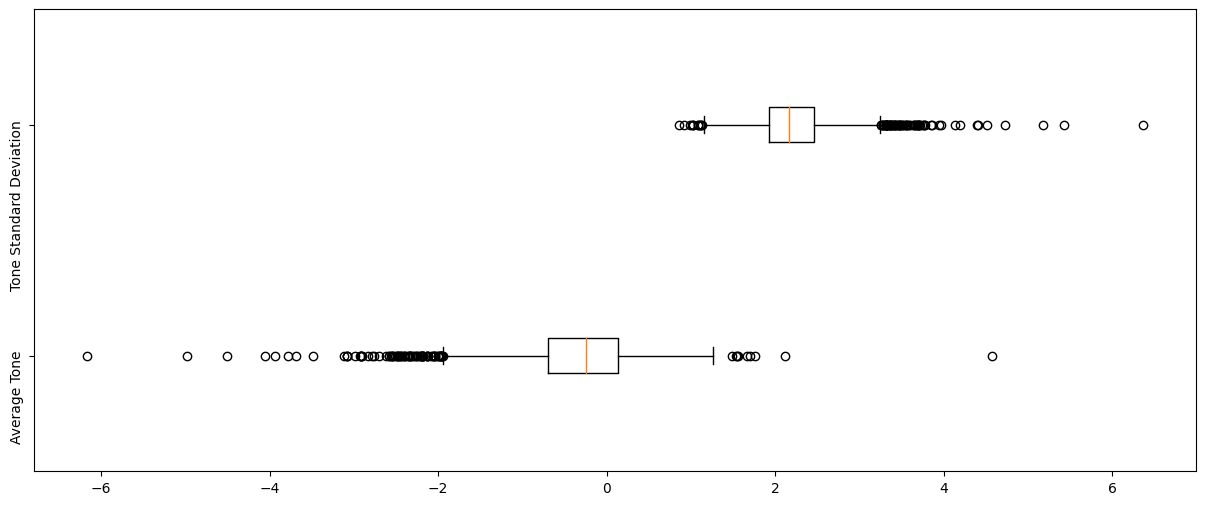

In [422]:
fig, ax = plt.subplots(figsize =(15, 6))

ax.boxplot(summary_df5[['tone_mean', 'tone_std']], vert=0)
plt.yticks([1, 2], ["Average Tone", "Tone Standard Deviation"], rotation=90)
plt.savefig(f"{results_dir}/task2_tone_boxplot.png")

plt.show()

### Report the number of outliers

In [424]:
outliers = []

for metric in ['tone_mean', 'tone_std']:
    up = len(summary_df5[summary_df5[metric] > daily_distribution.loc['upper whisker', metric]])
    low = len(summary_df5[summary_df5[metric] < daily_distribution.loc['lower whisker', metric]])
    tot = up + low
    up_per = up / len(summary_df5)
    low_per = low / len(summary_df5)
    tot_per = up_per + low_per
    outliers.append([up, low, tot, up_per, low_per, tot_per])

outliers_df = pd.DataFrame(outliers, index=['tone_mean', 'tone_std'], columns=['> Q3 + 1.5 IQR', '< Q1 - 1.5 IQR', 'total', 'upper percentage', 'lower percentage', 'total percentage'])
outliers_df.T

,tone_mean,tone_std
> Q3 + 1.5 IQR,9.000000,73.000000
< Q1 - 1.5 IQR,81.000000,12.000000
total,90.000000,85.000000
upper percentage,0.003247,0.026335
lower percentage,0.029221,0.004329
total percentage,0.032468,0.030664
